In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import random
import matplotlib.pyplot as plt
import string
from utils import *
from sklearn.datasets import *
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [11]:
import catboost
from catboost import CatBoostClassifier

## Load the dataset

In [12]:
from catboost.datasets import amazon

In [13]:
train, test = amazon()

In [16]:
# cardinality
train.apply(lambda x: len(x.unique()))

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [17]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [18]:
# ROLE_CODE == ROLE_TITLE
# removing one 
train.drop("ROLE_TITLE", axis=1, inplace=True)
test.drop("ROLE_TITLE", axis=1, inplace=True)

In [19]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,308574,118539
2,1,36724,14457,118219,118220,117884,267952,19721,117880
3,1,36135,5396,117961,118343,119993,240983,290919,118322
4,1,42680,5905,117929,117930,119569,123932,19793,119325


In [20]:
print("Ones", round(sum(train.ACTION == 1)/len(train),2))
print("Zeros", round(sum(train.ACTION == 0)/len(train),2))

Ones 0.94
Zeros 0.06


In [21]:
# Randomly splitting train-test data (80,20)
np.random.seed(10)
train_sub = train.iloc[np.random.permutation(train.index)[:26215],:].reset_index(drop=True)
valid_sub = train.iloc[np.random.permutation(train.index)[26215:],:].reset_index(drop=True)

In [22]:
train_sub.shape, valid_sub.shape

((26215, 9), (6554, 9))

## Modeling

Data is already numeric label encoded. So no need for that.

In [24]:
encoders = {"one_hot": one_hot_encoder, 
            "numeric_label": None,
            "kfold_target": kfold_target_encoder, 
            "catboost_target_encoder": catboost_target_encoder}

In [25]:
targetfeatures = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
                  'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

In [27]:
train_scores = {}
test_scores = {}
times = {}
for enc_name, enc in encoders.items():
    train_score = 0.
    test_score = 0.
    st = time.time()
    for i in range(1):  # just running once as this data is large
        train_score_this_iter, test_score_this_iter = fitmodel_and_auc_score(enc, 
                                                                             train_sub, 
                                                                             valid_sub,
                                                                             targetfeatures, 
                                                                             "ACTION") 
        train_score+=train_score_this_iter
        test_score+=test_score_this_iter
    # averaging score
    train_score/=1.
    test_score/=1.
    times[enc_name] = time.time()-st    
    train_scores[enc_name] = train_score
    test_scores[enc_name] = test_score

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [28]:
# now fitting on catboost
cat_features=range(8)
train_score = 0.
test_score = 0.
st = time.time()
for i in range(1):
    model = CatBoostClassifier(
        iterations=500,
        early_stopping_rounds=20, 
        eval_metric="AUC")

    model.fit(
        train_sub[targetfeatures], train_sub["ACTION"],
        cat_features=cat_features,
        eval_set=(valid_sub[targetfeatures], valid_sub["ACTION"]),
        verbose=False
    )
    
    train_score_this_iter = roc_auc_score(train_sub.ACTION, model.predict(train_sub[targetfeatures]))
    test_score_this_iter = roc_auc_score(valid_sub.ACTION, model.predict(valid_sub[targetfeatures]))
    train_score+=train_score_this_iter
    test_score+=test_score_this_iter
    # averaging score
train_score/=1.
test_score/=1.
times["catboost"] = time.time()-st    
train_scores["catboost"] = train_score
test_scores["catboost"] = test_score

In [35]:
train_scores.keys()[0]

TypeError: 'dict_keys' object is not subscriptable

In [33]:
[round(t,2) for t in train_scores.values()]

[0.73, 0.86, 0.88, 0.84, 0.93]

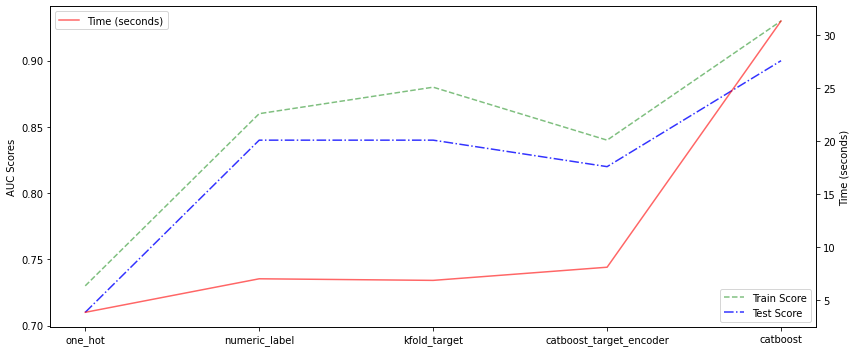

In [41]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

ax2 = ax.twinx()
ax.plot(list(train_scores.keys()), [round(t,2) for t in train_scores.values()], "--", color="g", alpha=0.5)
ax.plot(list(test_scores.keys()), [round(t,2) for t in test_scores.values()],  "-.", color="b", alpha=0.8)
ax2.plot(list(times.keys()), [round(t,2) for t in times.values()], color="r", alpha=0.6)
ax2.set_xlabel("Encoders")
ax.set_ylabel("AUC Scores")
ax2.set_ylabel("Time (seconds)")
ax2.yaxis.tick_right()
ax.legend(["Train Score", "Test Score"], loc="lower right")
ax2.legend(["Time (seconds)"])

fig.tight_layout()